In [1]:
import pandas as pd
import numpy as np
from statsmodels.discrete.discrete_model import Probit
import statsmodels.api as sm
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
from itertools import product
from termcolor import colored

# Preparación de los datos
#### Descripción de las caracteristicas ('features')
- ts:     Hora de inicio del flujo
- te:     Hora de finalización del flujo
- td:     Duración del flujo
- sa:     Dirección IP origen
- da:     Dirección IP de destino
- sp:     Puerto de origen
- dp:     Puerto de destino
- pr:     Protocolo
- flg:    Banderas
- fwd:    Estado de reenvío
- stos:   Tipo de servicio de origen
- ipkt:   Paquetes de entrada
- ibyt:   Bytes de entrada
- opkt:   Paquetes de salida
- obyt:   Bytes de salida
- in:     Interfaz de entrada
- out:    Interfaz de salida
- sas:    Número de sistema autónomo BGP de origen
- das:    Número de sistema autónomo BGP de destino
- smk:    Máscara de red de origen
- dmk:    Máscara de red de destino
- dtos:   Tipo de servicio de destino
- dir:    Dirección del flujo
- nh:     Enrutador de siguiente salto
- nhb:    Enrutador de siguiente salto BGP
- svln:   VLAN de origen
- dvln:   VLAN de destino
- ismc:   Dirección MAC de la fuente de entrada   
- odmc:   Dirección MAC de destino de salida
- idmc:   Introduzca la dirección MAC de destino
- osmc:   Dirección MAC de la fuente de salida
- mpls1:  Etiqueta MPLS 1
- mpls2:  Etiqueta MPLS 2
- mpls3:  Etiqueta MPLS 3
- mpls4:  Etiqueta MPLS 4
- mpls5:  Etiqueta MPLS 5
- mpls6:  Etiqueta MPLS 6
- mpls7:  Etiqueta MPLS 7
- mpls8:  Etiqueta MPLS 8
- mpls9:  Etiqueta MPLS 9
- mpls10: Etiqueta MPLS 10
- cl:     Latencia del cliente
- sl:     Latencia del servidor
- al:     Latencia de la aplicación
- ra:     Exportando la dirección IP del sistema (enrutador)
- eng:    Tipo / ID de motor
- exid:   Exportando el ID del sistema
- tr:     Marca de tiempo de flujo recibido
- type:   Tipo de registro Mina/ no Mina 
- cryptocurrency: : Tipo criptomoneda
- id_Cryptocurrency:: Id Criptomoneda

In [125]:
# Importamos el conjunto de datos
data = pd.read_csv('./dataA.csv')
data.head()

,index,References,ts,te,td,sa,da,sp,dp,pr,...,cl,sl,al,ra,eng,exid,tr,cryptocurrency,id_Cryptocurrency,type
0,33812,134-csves/0.csv,2020-09-10 08:48:49,2020-09-10 08:48:59,9.557,120.55.220.55,192.168.0.13,443.0,56780.0,TCP,...,0.0,0.0,0.0,0.0.0.0,0/0,0.0,1969-12-31 19:00:00.000,NaN,0,not_mine
1,227478,653-csves/0.csv,2020-09-15 19:33:50,2020-09-15 19:33:50,0.000,104.91.165.202,192.168.0.13,80.0,45158.0,TCP,...,0.0,0.0,0.0,0.0.0.0,0/0,0.0,1969-12-31 19:00:00.000,NaN,0,not_mine
2,287057,834-csves/0.csv,2020-09-17 16:16:41,2020-09-17 16:19:42,180.220,192.168.0.13,23.52.112.10,58542.0,443.0,TCP,...,0.0,0.0,0.0,0.0.0.0,0/0,0.0,1969-12-31 19:00:00.000,NaN,0,not_mine
3,387249,1121-csves/0.csv,2020-09-20 12:20:12,2020-09-20 12:20:12,0.000,192.168.0.13,13.35.111.67,58192.0,443.0,TCP,...,0.0,0.0,0.0,0.0.0.0,0/0,0.0,1969-12-31 19:00:00.000,NaN,0,not_mine
4,236501,682-csves/0.csv,2020-09-16 14:09:03,2020-09-16 14:09:52,49.616,192.168.0.13,200.196.225.98,60108.0,443.0,TCP,...,0.0,0.0,0.0,0.0.0.0,0/0,0.0,1969-12-31 19:00:00.000,NaN,0,not_mine


### Estructuración del conjunto de datos
Agrupo las columnas de tipo int64, float64 y object por separado, para hacer una analisis mas organizado

In [126]:
data_numeric_int = (data.dtypes == "int64")
data_numeric_float = (data.dtypes == "float64")
data_object  = (data.dtypes == "object")
data_numeric_int = [c for c in data_numeric_int.index if data_numeric_int[c]]
data_numeric_float = [c for c in data_numeric_float.index if data_numeric_float[c]]
data_object = [c for c in data_object.index if data_object[c]]

In [127]:
y = data['type']
X = data.drop('type', axis=1)
X_Continua = data[data_numeric_float]
X_Continua.head()

,td,sp,dp,fwd,stos,ipkt,ibyt,opkt,obyt,in,...,smk,dmk,dtos,dir,svln,dvln,cl,sl,al,exid
0,9.557,443.0,56780.0,0.0,0.0,13.0,9974.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000,80.0,45158.0,0.0,0.0,1.0,32.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,180.220,58542.0,443.0,0.0,0.0,5.0,160.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000,58192.0,443.0,0.0,0.0,1.0,32.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,49.616,60108.0,443.0,0.0,0.0,114.0,2566.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [128]:
X_Continua = X_Continua[['td','ipkt','ibyt','sp','dp']]

In [129]:
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
values = imputer.fit_transform(X_Continua)

In [130]:
X_Continua = pd.DataFrame(values, columns = X_Continua.columns, index = X_Continua.index)
X_Continua.head().T

,0,1,2,3,4
td,9.557,0.0,180.22,0.0,49.616
ipkt,13.000,1.0,5.00,1.0,114.000
ibyt,9974.000,32.0,160.00,32.0,2566.000
sp,443.000,80.0,58542.00,58192.0,60108.000
dp,56780.000,45158.0,443.00,443.0,443.000


In [131]:
y = y.replace({'not_mine': 0, 'mine': 1})

In [132]:
probit_model = Probit(y,X_Continua.astype(float)).fit()
print(probit_model.summary())

Optimization terminated successfully.
         Current function value: 0.189522
         Iterations 10
                          Probit Regression Results                           
Dep. Variable:                   type   No. Observations:               465084
Model:                         Probit   Df Residuals:                   465079
Method:                           MLE   Df Model:                            4
Date:                Thu, 01 Oct 2020   Pseudo R-squ.:                 -0.4780
Time:                        17:55:41   Log-Likelihood:                -88144.
converged:                       True   LL-Null:                       -59637.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
td             0.0027   3.77e-05     71.871      0.000       0.003       0.003
ipkt         7.98e-05   1.81

In [133]:
def accounts(name_x, name_y,tuples):
    acounts = []
    for i in range(len(tuples)):
        acounts.append(data[(data[name_x] == tuples[i][0]) & (data[name_y] == tuples[i][1])].shape[0])
    
    return acounts

In [134]:
def table_contingency(timon):
    temp_value = []
    for i in timon.index.levels[0]:
        temp_value.append(timon[i][0])
        temp_value.append(timon[i][1])
    temp_value = np.array(temp_value).reshape(2,len(timon.index.levels[0].values),order='F')
    temp_value = pd.DataFrame(temp_value, index = timon.index.levels[1].values[::-1], columns = timon.index.levels[0].values)
    return temp_value

In [135]:
def mosaic_plot(timon, titulo):
    mosaic(timon, title=titulo)
    plt.show()

In [196]:
def parametros(c_x,c_y):
    temp_x = list(data[c_x].unique())
    temp_x = pd.Series(temp_x).dropna()
    temp_x = list(temp_x)
    temp_y = list(data[c_y].unique())
    tuples = list(product(temp_x, temp_y))
    acoun = accounts(c_x, c_y,tuples)
    index = pd.MultiIndex.from_tuples(tuples, names=['first', 'second'])
    return acoun, tuples, index

['TCP', 'UDP', 'ICMP', 'ICMP6']
Tabla de contingencia
          ICMP  ICMP6     TCP     UDP
not_mine   195    386  333601  117762
mine         0      0   13032       0


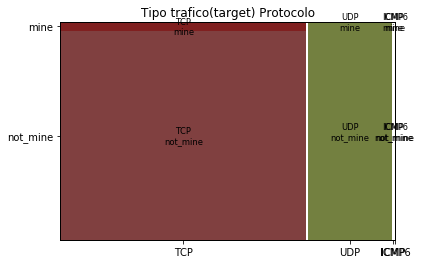

In [193]:
acoun, tuples, index = parametros('pr','type')
timon = pd.Series(acoun, index=index)
print(colored(f'Tabla de contingencia',attrs=['bold']))
print(table_contingency(timon))
mosaic_plot(timon, "Tipo trafico(target) Protocolo")

['Monero', 'Etherium', 'Litecoin', 'Bitcoin', 'Bitcash']
Tabla de contingencia
          Bitcash  Bitcoin  Etherium  Litecoin  Monero
not_mine        0        0         0         0       0
mine         1010      762     10147       756     414


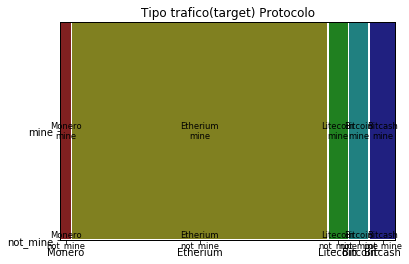

In [194]:
acoun, tuples, index = parametros('cryptocurrency','type')
timon = pd.Series(acoun, index=index)
print(colored(f'Tabla de contingencia',attrs=['bold']))
print(table_contingency(timon))
mosaic_plot(timon, "Tipo trafico(target) Protocolo")

['...AP.SF', '...A....', '...AP...', '........', '...APRSF', '...A...F', '...APR.F', '...A.R..', '...AP..F', '...AP.S.', '...A.R.F', '...A..S.', '...APRS.', '.....R..', '...A..SF', '...A.RSF', '...APR..', '......S.', '.....RS.', '...A.RS.']
Tabla de contingencia
          ........  ......S.  .....R..  .....RS.  ...A....  ...A...F  \
not_mine    118343       357      2697       274    130156     29398   
mine             0         1         0         0      1011        58   

          ...A..S.  ...A..SF  ...A.R..  ...A.R.F  ...A.RS.  ...A.RSF  \
not_mine       440       299      5392      8412         7        29   
mine             8         7         0         0         0         0   

          ...AP...  ...AP..F  ...AP.S.  ...AP.SF  ...APR..  ...APR.F  \
not_mine     15311     34100     48679     38399       817      1546   
mine         11250        63       134       496         2         0   

          ...APRS.  ...APRSF  
not_mine      9619      7669  
mine             2      

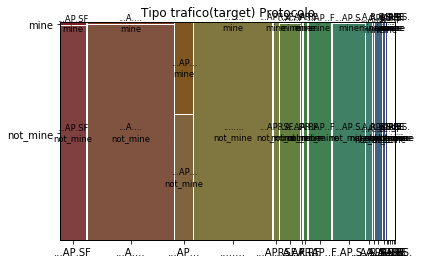

In [195]:
acoun, tuples, index = parametros('flg','type')
timon = pd.Series(acoun, index=index)
print(colored(f'Tabla de contingencia',attrs=['bold']))
print(table_contingency(timon))
mosaic_plot(timon, "Tipo trafico(target) Protocolo")

Tabla de contingencia
          0.0.0.0
not_mine   451944
mine        13032


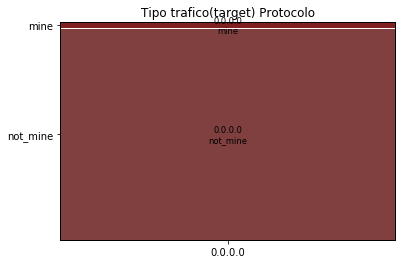

In [199]:
acoun, tuples, index = parametros('nh','type')
timon = pd.Series(acoun, index=index)
print(colored(f'Tabla de contingencia',attrs=['bold']))
print(table_contingency(timon))
mosaic_plot(timon, "Tipo trafico(target) Protocolo")